In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc

import healpy as hp
from scipy.special import sph_harm
import fitsio
import skyproj
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
import generate_mocks as gm

In [3]:
plt.rcParams["font.family"] = "serif"

## quasar catalogs

In [4]:
blim = 30
nside_hi = 64
resdir = '/scratch/aew492/lss-dipoles_results/results'

In [5]:
# expected dipole direction
cmb_dipdir = dipole.cmb_dipole()[1]

#### Quaia

In [6]:
# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_zodi', nside=nside_hi, blim=blim)

# load data
# masked
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# the above map smoothed to 1sr
quaia_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_smoothed_1sr.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
# load the selfunc-corrected, smoothed map
quaia_qmap_corr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked_corr_smoothed_1sr.npy'))

# base rate for mocks
base_rate_quaia = 33.6330

In [7]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

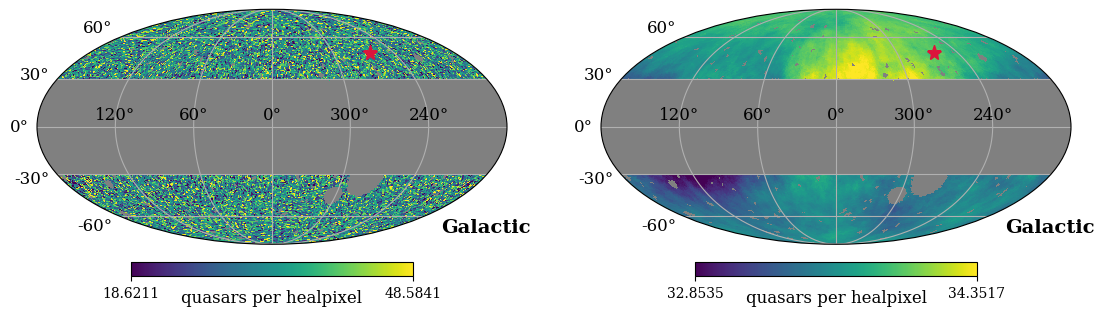

In [8]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.projview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)
hp.projview(quaia_qmap_corr_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)

In [9]:
# Quaia G<20.5
selfunc_quaia_205 = gm.get_selfunc_map('quaia_G20.5_orig', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.5.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
quaia_205 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_205[quaia_205 == 0.] = np.nan
# correct by selfunc
quaia_205_corr = quaia_205 / selfunc_quaia_205
# convert to overdensity map
odmap_quaia_205_corr = quaia_205_corr / np.nanmean(quaia_205_corr) - 1

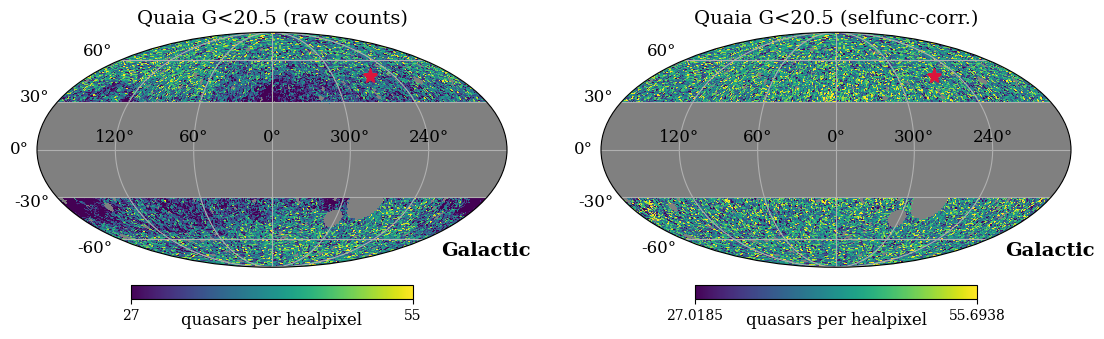

In [10]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_205), np.nanstd(quaia_205)
hp.projview(quaia_205, min=27, max=55, title='Quaia G<20.5 (raw counts)', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)
mean, std = np.nanmean(quaia_205_corr), np.nanstd(quaia_205_corr)
hp.projview(quaia_205_corr, min=mean-2*std, max=mean+2*std, title='Quaia G<20.5 (selfunc-corr.)', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=14)

In [11]:
# Quaia G<20.0 zsplit2bin0
selfunc_quaia_zsplit2bin0 = gm.get_selfunc_map('quaia_G20.0_zsplit2bin0', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin0.fits', frame='icrs', nside=nside_hi)
# mask
small_masks = fitsio.read(f'../data/masks/mask_master_hpx_r1.0.fits')
quaia_zsplit2bin0 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_zsplit2bin0[quaia_zsplit2bin0 == 0.] = np.nan
# correct by selfunc
quaia_zsplit2bin0_corr = quaia_zsplit2bin0 / selfunc_quaia_zsplit2bin0
# convert to overdensity map
odmap_quaia_zsplit2bin0_corr = quaia_zsplit2bin0_corr / np.nanmean(quaia_zsplit2bin0_corr) - 1

# Quaia G<20.0 zsplit2bin0
selfunc_quaia_zsplit2bin1 = gm.get_selfunc_map('quaia_G20.0_zsplit2bin1', nside=nside_hi, blim=blim)
# load catalog
qmap_raw = tools.load_catalog_as_map(f'../data/catalogs/quaia/quaia_G20.0_zsplit2bin1.fits', frame='icrs', nside=nside_hi)
quaia_zsplit2bin1 = qmap_raw * small_masks * tools.get_galactic_plane_mask(blim, nside=nside_hi, frame='icrs')
quaia_zsplit2bin1[quaia_zsplit2bin1 == 0.] = np.nan
# correct by selfunc
quaia_zsplit2bin1_corr = quaia_zsplit2bin1 / selfunc_quaia_zsplit2bin1
# convert to overdensity map
odmap_quaia_zsplit2bin1_corr = quaia_zsplit2bin1_corr / np.nanmean(quaia_zsplit2bin1_corr) - 1

#### CatWISE

In [12]:
# selfunc
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)

# load data
# masked
catwise_qmap = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked.npy'))
# the above map smoothed to 1sr
catwise_qmap_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_smoothed_1sr.npy'))
# selfunc-corrected
catwise_qmap_corr_elatcorr = catwise_qmap / selfunc_catwise_elatcorr
catwise_qmap_corr_zodi = catwise_qmap / selfunc_catwise_zodi
# selfunc-corrected and smoothed
catwise_qmap_corr_elatcorr_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_elatcorr_smoothed_1sr.npy'))
catwise_qmap_corr_zodi_smoothed = np.load(os.path.join(resdir, '../data/catalogs/catwise_agns/catwise_agns_masked_corr_zodi_smoothed_1sr.npy'))

# base rate for mocks
base_rate_catwise = 77.4495

In [13]:
# hp.fit_dipole result with elatcorr (should match S21 result)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [14]:
# hp.fit_dipole result with selfunc including zodi
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_zodi)[1] / hp.fit_dipole(catwise_qmap_corr_zodi)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dipamp, dipdir.galactic

(0.012374339860876405,
 <SkyCoord (Galactic): (l, b) in deg
     (191.77921627, 34.8197164)>)

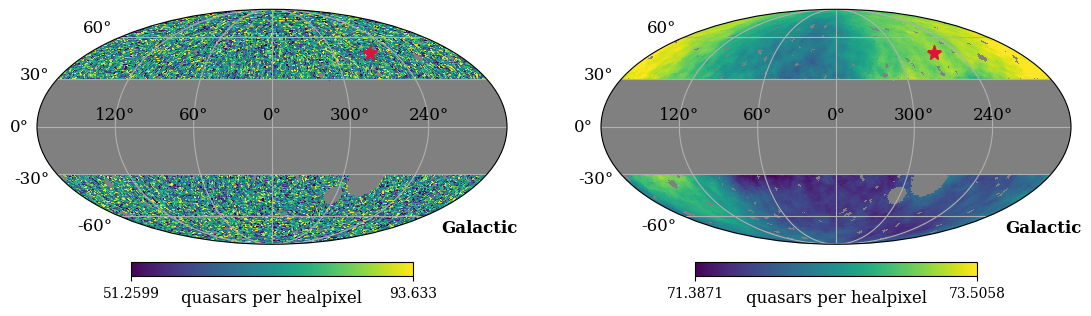

In [15]:
# plot
fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap='viridis', unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(catwise_qmap_corr_zodi), np.nanstd(catwise_qmap_corr_zodi)
hp.projview(catwise_qmap_corr_zodi, min=mean-2*std, max=mean+2*std, title='', sub=(1,2,1), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=12)
hp.projview(catwise_qmap_corr_zodi_smoothed, min=mean-0.1*std, max=mean+0.1*std, title='', sub=(1,2,2), **kwargs)
# tools.plot_marker(dipdir.galactic.l, dipdir.galactic.b, marker='*', color='white', mec='k', ms=12)
tools.plot_marker(cmb_dipdir.galactic.l, cmb_dipdir.galactic.b, marker='*', color='crimson', ms=11)
tools.label_coord('Galactic', fs=12)

#### selection functions

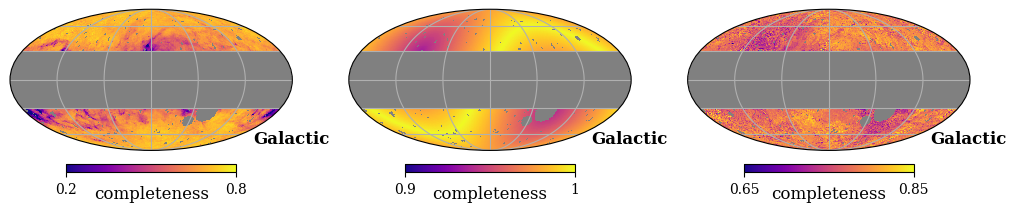

In [16]:
# plot
fig = plt.figure(figsize=(10,3))
kwargs = dict(coord=['C','G'], cmap='plasma', unit='completeness', fig=fig, graticule=True)#, badcolor='w')
selfunc_quaia_ = np.copy(selfunc_quaia)
selfunc_quaia_[selfunc_quaia <= 0.] = np.nan
selfunc_catwise_ = np.copy(selfunc_catwise_zodi)
selfunc_catwise_[selfunc_catwise_zodi <= 0.] = np.nan
selfunc_catwise_elatcorr_ = np.copy(selfunc_catwise_elatcorr)
selfunc_catwise_elatcorr_[selfunc_catwise_elatcorr_ <= 0.] = np.nan
hp.projview(selfunc_quaia_, title='', min=0.2, max=0.8, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_elatcorr_, title='', min=0.9, max=1., sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(selfunc_catwise_, title='', min=0.65, max=0.85, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

### dipole templates

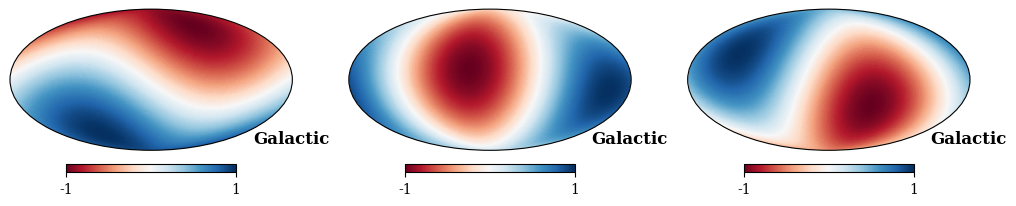

In [20]:
fig = plt.figure(figsize=(10,3))
comps = np.column_stack((np.zeros(3), np.diag([1, 1, 1])))
for i, comp in enumerate(comps):
    hp.projview(dipole.dipole_map(comp), coord=['C','G'], sub=(1, 3, i+1), cmap='RdBu', fig=fig, title='', min=-1, max=1)
    tools.label_coord('Galactic', fs=12)

### example mock generated from sky model

In [16]:
def case_dir(dipamp, log_excess, base_rate, selfunc_str, tag=''):
    return os.path.join(resdir, 'ABC/fake_data', f'dipole-{dipamp:.4f}_excess-1e{log_excess}_base-rate-{base_rate:.4f}{selfunc_str}{tag}')

In [17]:
input_dipamp = 0.0052
input_log_excess = -6.0
base_rate = 33.6330

nmocks = 500
ngens = 15

resdict = np.load(os.path.join(case_dir(input_dipamp, input_log_excess, base_rate, ''),
                               f'{nmocks}mocks_{ngens}gens_2025-03-03', 'results.npy'),
                  allow_pickle=True).item()
data = resdict['data']  # the data as raw quasar counts
selfunc = resdict['selfunc']
observation = resdict['observation']  # the data as overdensity
history = resdict['history']  # History object
prior = resdict['prior']  # dictionary
posterior = resdict['posterior']  # pandas dataframe and weights associated with the final posterior
old_posteriors = resdict['old_posteriors']  # posteriors from the otehr generations

In [18]:
# get the excess (all multipoles and dipole only) maps from the stored alms
excess_map = hp.sphtfunc.alm2map(data['alms'], 64)
excess_dipmap = hp.sphtfunc.alm2map(data['alms'][:3], 64)

# and the input kinematic dipole
cmb_dipdir = SkyCoord(264, 48, unit=u.deg, frame='galactic')
kinematic_comps = tools.spherical_to_cartesian(r=input_dipamp,
                                    theta=np.pi/2-cmb_dipdir.icrs.dec.rad,
                                    phi=cmb_dipdir.icrs.ra.rad)
kinematic_dipmap = dipole.dipole_map([0., *kinematic_comps])

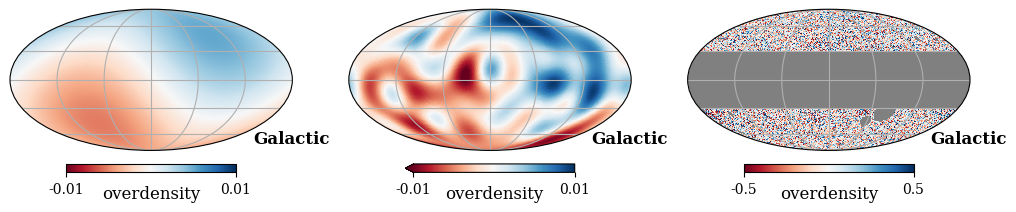

In [19]:
fig = plt.figure(figsize=(10,3))
kwargs = dict(coord=['C','G'], cmap='RdBu', unit='overdensity', fig=fig, title='', graticule=True) #, graticule_labels=True)
hp.projview(kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,1), **kwargs)
tools.label_coord('Galactic', fs=12)
hp.projview(excess_map + kinematic_dipmap, min=-0.01, max=0.01, sub=(1,3,2), **kwargs)
tools.label_coord('Galactic', fs=12)

datamap = data['data'].astype(float)
datamap[datamap == 0.] = np.nan
datamap_corr = datamap / selfunc
odmap_final = datamap_corr / np.nanmean(datamap_corr) - 1
hp.projview(odmap_final, min=-0.5, max=0.5, sub=(1,3,3), **kwargs)
tools.label_coord('Galactic', fs=12)

### "standard" dipole result (*note no regularization*)

#### Quaia

In [16]:
# hp.fit_dipole result
hp_dipole_quaia = hp.fit_dipole(quaia_qmap_corr)[1] / hp.fit_dipole(quaia_qmap_corr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_quaia)
dipamp, dipdir.galactic

(0.012918253969369827,
 <SkyCoord (Galactic): (l, b) in deg
     (303.15911297, 28.84933189)>)

In [17]:
# my function
# convert to overdensity map
odmap_quaia_corr = quaia_qmap_corr / np.nanmean(quaia_qmap_corr) - 1

# without weighting by selection function in fit (Cinv=identity) (this should match hp.fit_dipole)
dipamp1, dipdir1 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=None))
dirstr1 = f"({dipdir1.galactic.l.deg:.1f}, {dipdir1.galactic.b.deg:.1f})"
sep1 = dipdir1.separation(cmb_dipdir)

# with the Quaia selection function as Cinv in the fit
dipamp2, dipdir2 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_corr, 0., selfunc=selfunc_quaia))
dirstr2 = f"({dipdir2.galactic.l.deg:.1f}, {dipdir2.galactic.b.deg:.1f})"
sep2 = dipdir2.separation(cmb_dipdir)

# with Quaia G<20.5
dipamp_205, dipdir_205 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_205_corr, 0., selfunc=selfunc_quaia_205))
dirstr_205 = f"({dipdir_205.galactic.l.deg:.1f}, {dipdir_205.galactic.b.deg:.1f})"
sep_205 = dipdir_205.separation(cmb_dipdir)

# zsplits
dipamp_bin0, dipdir_bin0 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_zsplit2bin0_corr, 0.,
                                                                                      selfunc=selfunc_quaia_zsplit2bin0))
dirstr_zsplit2bin0 = f"({dipdir_bin0.galactic.l.deg:.1f}, {dipdir_bin0.galactic.b.deg:.1f})"
sep_zsplit2bin0 = dipdir_bin0.separation(cmb_dipdir)

dipamp_bin1, dipdir_bin1 = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap_quaia_zsplit2bin1_corr, 0.,
                                                                                      selfunc=selfunc_quaia_zsplit2bin1))
dirstr_zsplit2bin1 = f"({dipdir_bin1.galactic.l.deg:.1f}, {dipdir_bin1.galactic.b.deg:.1f})"
sep_zsplit2bin1 = dipdir_bin1.separation(cmb_dipdir)

# expected amplitude
cmb_dipamp = 0.0052

# fancy print statements
print(f"{'selection function:':<35}{'Dipole amp:':<20}{'Relative to expected:':<25}{'Dipole dir: (l, b) (deg)':<30}{'Angle to CMB dipole (deg):'}")
print('=' * 140)
print(f"{'Quaia G<20.0 with none:':<35}{dipamp1:<20.5f}{dipamp1 / cmb_dipamp:<25.2f}{dirstr1:<30}{sep1.deg:.2f}")
print(f"{'Quaia G<20.0 with zodi:':<35}{dipamp2:<20.5f}{dipamp2 / cmb_dipamp:<25.2f}{dirstr2:<30}{sep2.deg:.2f}")
print(f"{'Quaia G<20.5 with orig:':<35}{dipamp_205:<20.5f}{dipamp_205 / cmb_dipamp:<25.2f}{dirstr_205:<30}{sep_205.deg:.2f}")
print(f"{'Quaia G<20.0 zsplit2bin0:':<35}{dipamp_bin0:<20.5f}{dipamp_bin0 / cmb_dipamp:<25.2f}{dirstr_zsplit2bin0:<30}{sep_zsplit2bin0.deg:.2f}")
print(f"{'Quaia G<20.5 zsplit2bin1:':<35}{dipamp_bin1:<20.5f}{dipamp_bin1 / cmb_dipamp:<25.2f}{dirstr_zsplit2bin1:<30}{sep_zsplit2bin1.deg:.2f}")

selection function:                Dipole amp:         Relative to expected:    Dipole dir: (l, b) (deg)      Angle to CMB dipole (deg):
Quaia G<20.0 with none:            0.01292             2.48                     (303.2, 28.8)                 35.61
Quaia G<20.0 with zodi:            0.01173             2.26                     (298.9, 30.8)                 31.58
Quaia G<20.5 with orig:            0.02109             4.06                     (336.5, 32.4)                 55.40
Quaia G<20.0 zsplit2bin0:          0.01609             3.09                     (317.1, 37.3)                 39.69
Quaia G<20.5 zsplit2bin1:          0.01916             3.68                     (316.2, 22.7)                 48.35


#### CatWISE

In [18]:
# hp.fit_dipole result (*we expect this to be the S21 result, since we've corrected with 'elatcorr' selfunc*)
hp_dipole_catwise = hp.fit_dipole(catwise_qmap_corr_elatcorr)[1] / hp.fit_dipole(catwise_qmap_corr_elatcorr)[0]  # returns monopole and then 3 dipole components
dipamp, dipdir = dipole.get_dipole(hp_dipole_catwise)
dirstr = f"({dipdir.galactic.l.deg:.1f}, {dipdir.galactic.b.deg:.1f})"
sep = dipdir.separation(cmb_dipdir)
dipamp, dipdir.galactic

(0.015334348323861371,
 <SkyCoord (Galactic): (l, b) in deg
     (237.73551446, 28.88093137)>)

In [19]:
# load relevant selfuncs
selfunc_catwise = gm.get_selfunc_map('catwise', nside=nside_hi, blim=blim)
selfunc_catwise_zodi = gm.get_selfunc_map('catwise_zodi', nside=nside_hi, blim=blim)
selfunc_catwise_elatcorr = gm.get_selfunc_map('catwise_elatcorr', nside=nside_hi, blim=blim)

# expected amplitude
cmb_dipamp = 0.0074

# fancy print statements
print(f"{'selection function:':<35}{'Dipole amp:':<20}{'Relative to expected:':<25}{'Dipole dir: (l, b) (deg)':<30}Angle to CMB dipole (deg):")
print('=' * 130)
print(f"{'none:':<35}{dipamp:<20.5f}{dipamp / cmb_dipamp:<25.2f}{dirstr:<30}{sep.deg:.2f}")

tags = ['CatWISE fiducial:', 'CatWISE elatcorr (S21):', 'CatWISE no zodi:']
odmaps_catwise_corr = []
dipdirs = []
dipamps = []
for i, selfunc in enumerate([selfunc_catwise_zodi, selfunc_catwise_elatcorr, selfunc_catwise]):
    qmap_corr = catwise_qmap / selfunc
    odmap = qmap_corr / np.nanmean(qmap_corr) - 1
    odmaps_catwise_corr.append(odmap)
    dipamp, dipdir = dipole.get_dipole(dipole.measure_overdensity_dipole_Lambda(odmap, 0., selfunc=selfunc))
    dirstr = f"({dipdir.galactic.l.deg:.1f}, {dipdir.galactic.b.deg:.1f})"
    sep = dipdir.separation(cmb_dipdir)
    dipdirs.append(dipdir)
    dipamps.append(dipamp)
    print(f"{tags[i]:<35}{dipamp:<20.5f}{dipamp / cmb_dipamp:<25.2f}{dirstr:<30}{sep.deg:.2f}")

selection function:                Dipole amp:         Relative to expected:    Dipole dir: (l, b) (deg)      Angle to CMB dipole (deg):
none:                              0.01533             2.07                     (237.7, 28.9)                 27.83
CatWISE fiducial:                  0.01245             1.68                     (191.4, 34.7)                 53.97
CatWISE elatcorr (S21):            0.01532             2.07                     (238.0, 28.8)                 27.75
CatWISE no zodi:                   0.01156             1.56                     (197.2, 43.8)                 45.19


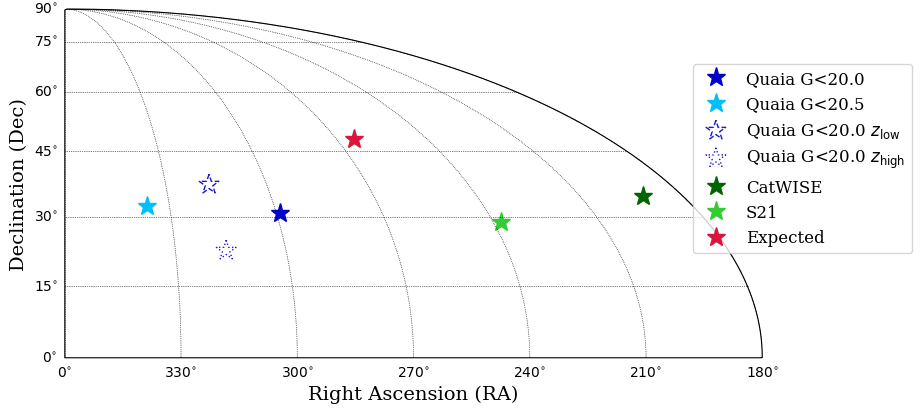

In [20]:
fig, ax = plt.subplots(figsize=(9,6))
sp = skyproj.MollweideSkyproj(ax=ax, extent=[180, 360, 0, 90])
sp.ax.tick_params(fontsize=16)
kwargs = dict(marker='*', ms=14, alpha=1, ls='None')

sp.plot(dipdir2.galactic.l.deg, dipdir2.galactic.b.deg, color='mediumblue',
        label=f'Quaia G<20.0', **kwargs)#{"Quaia G<20.0:":<25}'r'$|\vec{\mathcal{D}_k}|=$'f'{dipamp2:.4f}', **kwargs)
sp.plot(dipdir_205.galactic.l.deg, dipdir_205.galactic.b.deg, color='deepskyblue',
        label=f'Quaia G<20.5', **kwargs)# {"Quaia G<20.5:":<25}'r'$|\vec{\mathcal{D}_k}|=$'f'{dipamp_205:.4f}', **kwargs)
sp.scatter(dipdir_bin0.galactic.l.deg, dipdir_bin0.galactic.b.deg, color='None', edgecolors='mediumblue', linestyle='--',
        label=f'Quaia G<20.0 'r'$z_\mathrm{low}$', marker='*', s=220, alpha=0.9)# :'f'\t   'r'$|\vec{\mathcal{D}_k}|=$'f'{dipamp_bin0:.4f}', marker='*', s=220, alpha=0.9)
sp.scatter(dipdir_bin1.galactic.l.deg, dipdir_bin1.galactic.b.deg, color='None', edgecolors='mediumblue', linestyle=':',
        label=f'Quaia G<20.0 'r'$z_\mathrm{high}$', marker='*', s=220, alpha=0.9)# 'r'$z_\mathrm{high}$:'f'\t   'r'$|\vec{\mathcal{D}_k}|=$'f'{dipamp_bin1:.4f}')

labels = [
    'CatWISE',
    'S21',
    'CatWISE no zodi'
]
for i, (c, dipdir, dipamp, label) in enumerate(zip(['darkgreen', 'limegreen'], dipdirs, dipamps, labels)):
    sp.plot(dipdir.galactic.l.deg, dipdir.galactic.b.deg, color=c, label=label, **kwargs)#{label}:\t'r'$|\vec{\mathcal{D}}|=$'f'{dipamp:.4f}', **kwargs)

sp.plot(cmb_dipdir.galactic.l.deg, cmb_dipdir.galactic.b.deg, color='crimson', 
        label=f'Expected', **kwargs)#{"Expected:":<28}'r'$|\vec{\mathcal{D}_k}|=$'f'{cmb_dipamp:.4f}', **kwargs)
sp.legend(loc=(0.9, 0.3), fontsize=12)
sp.ax.set_xlabel('Right Ascension (RA)', fontsize=14)
sp.ax.set_ylabel('Declination (Dec)', fontsize=14)
sp.ax.tick_params(fontsize=12)
sp.ax.gridlines.set_alpha(0.4)

## ABC results

In [17]:
resdir = '/scratch/aew492/lss-dipoles_results/results'
nside = 2

### `dipole_amp` as only free parameter

In [18]:
def get_abc_results_dipole_only(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = q_dipamp[1] / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, ax = plt.subplots(figsize=(5,4), tight_layout=True)
    label = 'Dipole amplitude in CMB dir.'
    
    df, w = posterior
    
    # quantiles?
    q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
    
    # diagonal
    ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
    ax.axvspan(q[0], q[2], color='k', alpha=0.05)
    ax.axhline(0., c='k', alpha=0.5, lw=0.5)
    ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
    ax.legend()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
    if xticks is not None:
        ax.set_xticks(xticks)
    ax.axvline(0., c='k', alpha=0.5, lw=0.5)
    
    x, pdf = tools.get_kde_1d([df, w], prior, par_id)
    ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)
    
    ax.set_ylabel(label)
    ax.set_xlabel(label)

    if title is not None:
        ax.set_title(title)

    return q_dipamp, relamp, z

In [19]:
sample_names = []
quantiles = []
relamps = []
zscores = []

#### Quaia G<20.0 with zodi

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0088
std dipole_amp = 0.0024
z score = -1.5129


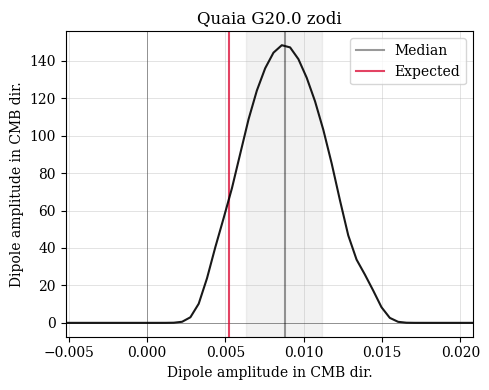

In [20]:
sample_name = 'quaia_G20.0_zodi'
q, relamp, z = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)

#### Quaia G<20.5

expected dipole_amp = 0.0047
mean dipole_amp = 0.0126
median dipole_amp = 0.0125
std dipole_amp = 0.0025
z score = -3.1497


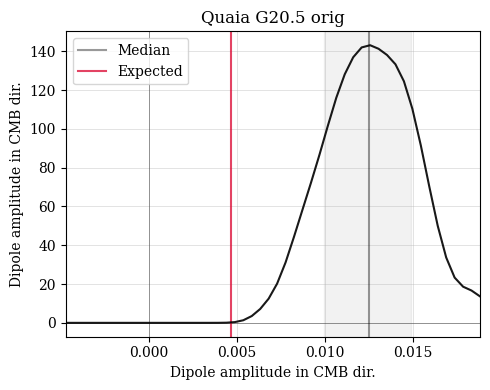

In [21]:
sample_name = 'quaia_G20.5_orig'
q, relamp, z = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'),
                                          title='Quaia G20.5 orig')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)

#### Quaia G<20.0 zsplit2bin0

expected dipole_amp = 0.005
mean dipole_amp = 0.0105
median dipole_amp = 0.0110
std dipole_amp = 0.0030
z score = -1.9801


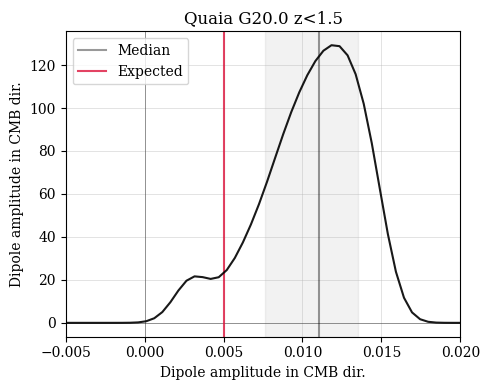

In [22]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q, relamp, z = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'),
                                          title='Quaia G20.0 z<1.5')
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)

#### CatWISE with zodi

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0090
std dipole_amp = 0.0019
z score = -0.8677


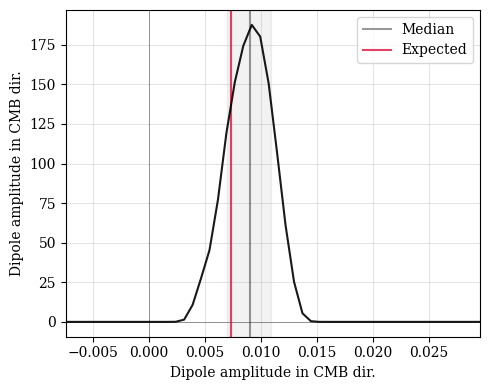

In [23]:
sample_name = 'catwise_zodi'
q, relamp, z = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)

#### CatWISE with elatcorr

expected dipole_amp = 0.0074
mean dipole_amp = 0.0120
median dipole_amp = 0.0120
std dipole_amp = 0.0019
z score = -2.4360


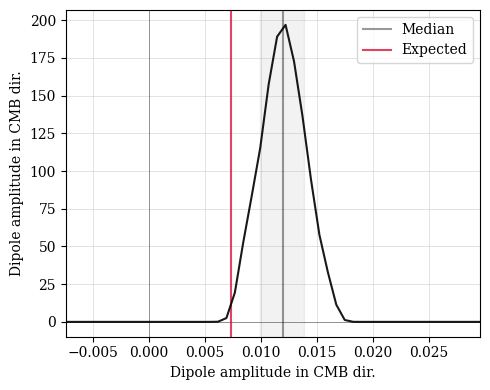

In [24]:
sample_name = 'catwise_elatcorr'
q, relamp, z = get_abc_results_dipole_only(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_only_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'))
sample_names.append(sample_name)
quantiles.append(q)
relamps.append(relamp)
zscores.append(z)

In [25]:
print(f"{'sample name:':30}{'dipole posterior:':30}{'relative amplitude:':25}{'z score:'}")
q_dipamp_strs = [
    f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}' for q in quantiles
]
relamp_strs = [
    f'{relamp:.3f}' for relamp in relamps
]
zscore_strs = [
    f'{z:.3f}' for z in zscores
]
print('=' * 110)
assert len(sample_names) == len(q_dipamp_strs)
for i, sample_name in enumerate(sample_names):
    print(f"{sample_name:30}{q_dipamp_strs[i]:30}{relamp_strs[i]:25}{zscore_strs[i]}")

sample name:                  dipole posterior:             relative amplitude:      z score:
quaia_G20.0_zodi              0.0088 +0.0024 -0.0025        1.690                    -1.513
quaia_G20.5_orig              0.0125 +0.0024 -0.0025        2.660                    -3.150
quaia_G20.0_zsplit2bin0       0.0110 +0.0025 -0.0034        2.203                    -1.980
catwise_zodi                  0.0090 +0.0019 -0.0021        1.222                    -0.868
catwise_elatcorr              0.0120 +0.0019 -0.0020        1.618                    -2.436


### `dipole_amp` and `log_excess`

In [98]:
def get_abc_results_dipole_excess(fn, xticks=None, title=None):

    res = np.load(fn, allow_pickle=True).item()
    history = res['history']
    prior = res['prior']
    posterior = res['posterior']
    selfunc = res['selfunc']
    expected_dipamp = res['expected_dipole_amp']
    print(f"expected dipole_amp = {expected_dipamp}")
    
    # quantiles
    df, w = posterior
    q_dipamp = tools.quantile(df['dipole_amp'], [0.16, 0.5, 0.84], weights=w)
    q_excess = tools.quantile(df['log_excess'], [0.16, 0.5, 0.84], weights=w)

    # calculate the sigma discrepancy: ****check with Kate and Hogg: is this the right way to do this?
    # z score is z = (x_0 - \mu) / \sigma , where x_0 is the null hypothesis, \mu is mean (or MAP? or median?)
    #    and \sigma = std. of the posterior
    
    # how different is the mean from the median?
    print(f"mean dipole_amp = {pyabc.weighted_statistics.weighted_mean(df['dipole_amp'], w):.4f}")
    print(f"median dipole_amp = {q_dipamp[1]:.4f}")
    mu = q_dipamp[1]
    
    # standard deviation
    sigma = pyabc.weighted_statistics.weighted_std(df['dipole_amp'], w)
    print(f"std dipole_amp = {sigma:.4f}")

    relamp = q_dipamp[1] / expected_dipamp
    
    # z score
    z = (expected_dipamp - mu) / sigma
    print(f"z score = {z:.4f}")

    # plot (copied and adjusted from the pyabc.visualization source code)
    par_id = [x for x in prior.keys()][0]
    fig, axs = plt.subplots(2, 2, figsize=(7,6), tight_layout=True)
    
    df, w = posterior

    par_ids = [x for x in prior.keys()]
    labels = [r'$|\vec{\mathcal{D}}_{\mathrm{proj},k}|$', r'$\log \bar C$']  # bug: these labels are hard-coded

    for i, par_id in enumerate(par_ids):
    
        # quantiles?
        q = tools.quantile(df[par_id], [0.16, 0.5, 0.84], weights=w)
        
        # diagonal
        ax = axs[i, i]
        ax.axvline(q[1], c='k', alpha=0.4, ls='-', label='Median')
        ax.axvspan(q[0], q[2], color='k', alpha=0.05)
        ax.axhline(0., c='k', alpha=0.5, lw=0.5)
        ax.axvline(expected_dipamp, c='crimson', alpha=0.8, lw=1.5, label='Expected')
        ax.legend()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(prior[par_id].args[0], prior[par_id].args[0] + prior[par_id].args[1])
        if xticks is not None:
            ax.set_xticks(xticks)
        ax.axvline(0., c='k', alpha=0.5, lw=0.5)
        
        x, pdf = tools.get_kde_1d([df, w], prior, par_id)
        ax.plot(x, pdf, c='k', alpha=0.9, lw=1.5)

        axs[i,0].set_ylabel(labels[i], fontsize=12)
        axs[len(par_ids)-1,i].set_xlabel(labels[i], fontsize=12)

        for j in range(0, i):
    
            # lower
            ax = axs[i, j]
            x, y, pdf = tools.get_kde_2d([df, w], prior, par_ids[j], par_id)
            mesh = ax.pcolormesh(x, y, pdf, shading='auto', cmap='binary')
    
            # upper
            ax = axs[j, i]
            tools.scatter([df, w], prior, par_id, par_ids[j], ax, color='k', alpha=0.5, marker='.', s=3)
            ax.grid(alpha=0.5, lw=0.5)
    
    if title is not None:
        fig.suptitle(title)
    
    return q_dipamp, q_excess, relamp, z

In [99]:
sample_names = []
quantiles_amp = []
quantiles_excess = []
relamps = []
zscores = []

#### Quaia G<20.0 with zodi

expected dipole_amp = 0.0052
mean dipole_amp = 0.0088
median dipole_amp = 0.0087
std dipole_amp = 0.0026
z score = -1.3762


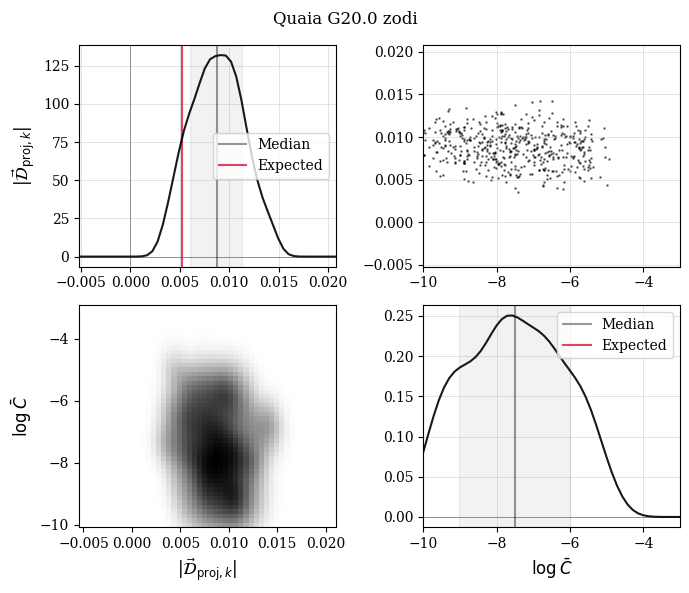

In [100]:
sample_name = 'quaia_G20.0_zodi'
q_amp, q_excess, relamp, z = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_quaia:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

#### Quaia G<20.5

In [83]:
sample_name = 'quaia_G20.5_orig'
q_amp, q_excess, relamp, z = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{41.3560:.4f}/results.npy'),
                                          title='Quaia G20.5 orig')
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/aew492/lss-dipoles_results/results/ABC/quaia_G20.5_orig_dipole_excess_nside2_500mocks_18iters_base-rate-41.3560/results.npy'

#### Quaia G<20.0 zsplit2bin0

expected dipole_amp = 0.005
mean dipole_amp = 0.0124
median dipole_amp = 0.0124
std dipole_amp = 0.0033
z score = -2.2212


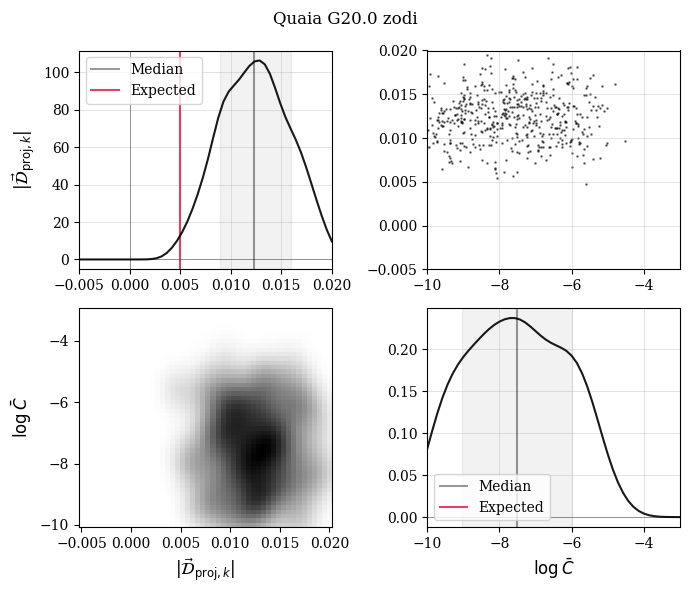

In [101]:
sample_name = 'quaia_G20.0_zsplit2bin0'
q_amp, q_excess, relamp, z = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{18.0810:.4f}/results.npy'),
                                          title='Quaia G20.0 zodi')
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

### CatWISE with zodi

expected dipole_amp = 0.0074
mean dipole_amp = 0.0090
median dipole_amp = 0.0091
std dipole_amp = 0.0022
z score = -0.7775


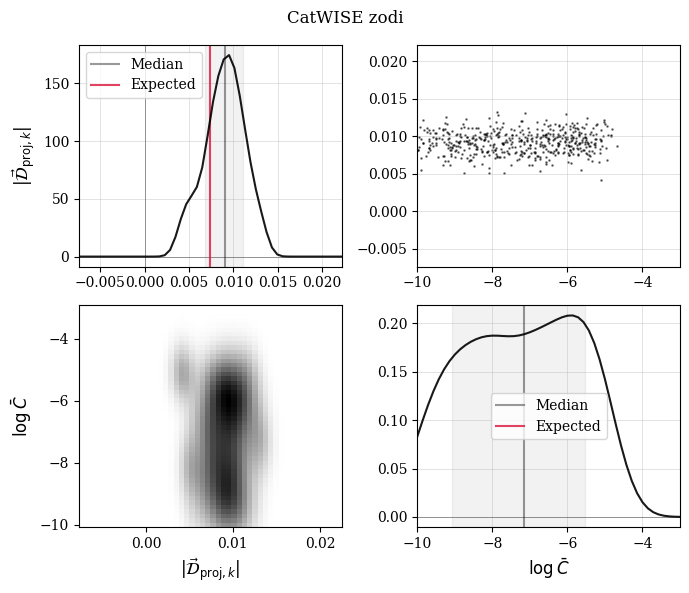

In [103]:
sample_name = 'catwise_zodi'
q_amp, q_excess, relamp, z = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE zodi')
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

#### CatWISE elatcorr

expected dipole_amp = 0.0074
mean dipole_amp = 0.0122
median dipole_amp = 0.0121
std dipole_amp = 0.0020
z score = -2.3245


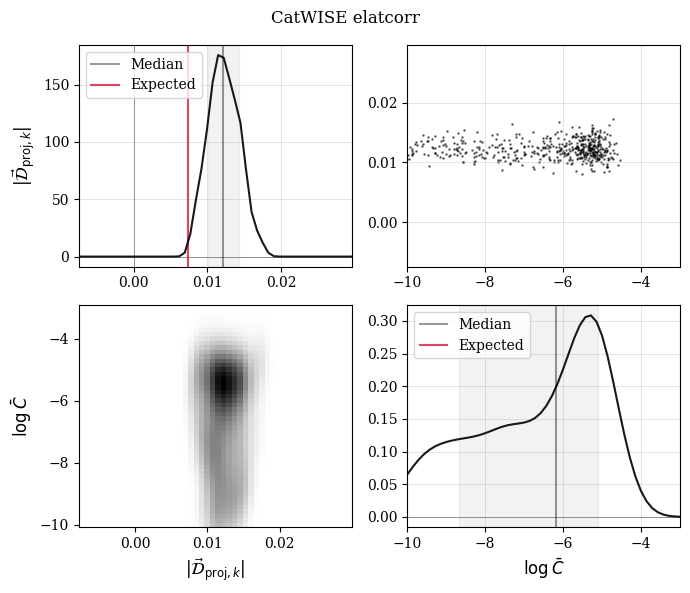

In [104]:
sample_name = 'catwise_elatcorr'
q_amp, q_excess, relamp, z = get_abc_results_dipole_excess(os.path.join(resdir,
                            f'ABC/{sample_name}_dipole_excess_nside{nside}_500mocks_18iters_base-rate-{base_rate_catwise:.4f}/results.npy'),
                                          title='CatWISE elatcorr')
sample_names.append(sample_name)
quantiles_amp.append(q_amp)
quantiles_excess.append(q_excess)
relamps.append(relamp)
zscores.append(z)

In [105]:
print(f"{'sample name:':30}{'dipole posterior:':30}{'log excess posterior:':30}{'relative amplitude:':25}{'z score:'}")
q_dipamp_strs = [
    f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}' for q in quantiles_amp
]
q_excess_strs = [
    f'{q[1]:.4f} +{q[2]-q[1]:.4f} -{q[1]-q[0]:.4f}' for q in quantiles_excess
]
relamp_strs = [
    f'{relamp:.3f}' for relamp in relamps
]
zscore_strs = [
    f'{z:.3f}' for z in zscores
]
print('=' * 130)
assert len(sample_names) == len(q_dipamp_strs) == len(q_excess_strs)
for i, sample_name in enumerate(sample_names):
    print(f"{sample_name:30}{q_dipamp_strs[i]:30}{q_excess_strs[i]:30}{relamp_strs[i]:25}{zscore_strs[i]}")

sample name:                  dipole posterior:             log excess posterior:         relative amplitude:      z score:
quaia_G20.0_zodi              0.0087 +0.0025 -0.0028        -7.4939 +1.4990 -1.5232       1.682                    -1.376
quaia_G20.0_zsplit2bin0       0.0124 +0.0036 -0.0034        -7.5222 +1.5288 -1.4980       2.470                    -2.221
catwise_zodi                  0.0091 +0.0020 -0.0023        -7.1543 +1.6295 -1.9109       1.231                    -0.778
catwise_elatcorr              0.0121 +0.0022 -0.0020        -6.1801 +1.0730 -2.4985       1.641                    -2.325
